# Sentiment Analysis

In [775]:
import bbcode
import re
import string
import spacy
from spacy.tokenizer import Tokenizer
import json

import nltk
from nltk import WordNetLemmatizer

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

### Steps:

1. Get text from all documents as 1 list of text
2. Turn this huge chunk of text into sentences
3. Tokenise all sentences for topic identification
4. Assign topics to each sentence
5. Using the untokenised sentences, tokenise the text for sentiment analysis
6. Get sentiment for each sentence and topic
7. Group sentiment by topic and get a count for positive sentiment against total reviews, by topic

In [123]:
#load dataset

final_data = pd.read_csv('./dataframes/dominant_topics.csv',index_col=0)

In [124]:
final_data.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4715,"['ton', 'diplomacy', 'joke', 'military_access'...",85,"['guess', 'artillery', 'chain', 'siege', 'sent...",57,"unit, battle, faction, army, general, characte..."
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
2,Series Authenticity,Absolutely great game. \nAll the new diplomacy...,0.9391,"['diplomacy_options', 'depth', 'unit_variety',...",10,"['warhammer', 'depth', 'combat', 'rt', 'diplom...",9,"three_kingdoms, series, fan, diplomacy, battle..."
3,Series Authenticity,A fine blend of Warhammer I/II: Total War and ...,0.6487,"['blend', 'warhammer_three', 'shogun_two', 'lo...",20,"['blend', 'warhammer_three', 'character', 'bat...",20,"three_kingdoms, series, fan, diplomacy, battle..."
4,Series Authenticity,Innovative Total Game that has lots of persona...,0.7290,"['personality', 'diplomacy', 'idea', 'combat',...",11,"['art_style', 'paid_dlc', 'combat', 'content',...",10,"three_kingdoms, series, fan, diplomacy, battle..."


# Preprocessing

In [125]:
#initialise BBcode parser and spacy NLP for parsing and tokenising sentences

nlp = spacy.load("en_core_web_sm")
parser = bbcode.Parser()

def parse(review):
    parsed_text = parser.strip(review)
    return parsed_text

#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [500]:
#Test NLP sentence tokeniser on one review

#generate test list of documents (just testing on 1 first to reduce clutter)
test_lst = [parse(x) for x in list(final_data['original_text'][:1])]

# credit to https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6 for the code below, which I modified for my use
for review in test_lst:
    print('Original Review: %s' % (review))
    print()
    doc = nlp(review)
    for i, sent in enumerate(doc.sents):
        print('-->Sentence %d: %s' % (i, sent.text))

Original Review: Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that supply you w

In [127]:
def parse_sent_tokenize(review):
    
    sent_tokens = [] #store sentence tokens here
    
    text = parse(review)  #remove BBcode first
    
    text = expandContractions(text)
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet. Do not remove stopwords yet.
    text = [word for word in text.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
   
    parsed_text = ' '.join(word for word in text)
    
    doc = nlp(parsed_text)
    for i,sent in enumerate(doc.sents):
        sent_tokens.append(sent.text)
    
    return sent_tokens

In [128]:
#test parse_sent_tokenize function
test_sents = parse_sent_tokenize(final_data['original_text'][0])
test_sents[:10]

['well for me game still tons of work.',
 'like it but just cant recommend.',
 '1.',
 'diplomacy',
 'it is joke.',
 'nothing works.',
 'you have trade and military access with cao cao war declaration next turn.',
 'you are too small',
 'well you will get war declaration each turn in this game',
 'its ok if you are at war with more factions than you have armies.']

In [130]:
#remove punctuation
def remove_punc(sents):
    clean_text = [s.translate(str.maketrans('', '', string.punctuation)) 
                  for s in sents]
    return clean_text

In [131]:
remove_punc(test_sents)[:10]

['well for me game still tons of work',
 'like it but just cant recommend',
 '1',
 'diplomacy',
 'it is joke',
 'nothing works',
 'you have trade and military access with cao cao war declaration next turn',
 'you are too small',
 'well you will get war declaration each turn in this game',
 'its ok if you are at war with more factions than you have armies']

In [1066]:
big_sent_lst =[] #For storing ALL sentences in the dataset. Doesn't matter which reviews they came from
sent_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst.extend(sent_tokens)

In [1067]:
sent_df['original_text'] = [x for x in big_sent_lst]
sent_df['token_sentences'] = [x.split() for x in big_sent_lst]
sent_df.head()

,original_text,token_sentences
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]"
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]"
2,1,[1]
3,diplomacy,[diplomacy]
4,it is joke,"[it, is, joke]"


In [1068]:
#This output looks ready for tokenisation into a model-readable format. 
#The single numbers and overly short sentences will likely result in 0 to 1 tokens, which will be dropped later as established in the Model Validation notebook.

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

sent_df['sents_unstopped'] = sent_df['token_sentences'].map(lambda x: remove_stopwords(x))

bigram = gensim.models.Phrases(list(sent_df['sents_unstopped']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to get bigrams]
trigram = gensim.models.Phrases(bigram[list(sent_df['sents_unstopped'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

#at this point we will make n-grams, then lemmatise using spacy since it can go by permitted postags

def spacy_lemma(bow,allowed_postags=['NOUN']):
    
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ if token.pos_ in allowed_postags else '' for token in lemma_doc]
    
    return lemma_text

In [1069]:
#WARNING! this cell can be a little slow, especially with larger datasets (it already takes ~3 minutes with 3600+ rows) -- will consider stemming as a future modification

sent_df['3gram_sentences'] = make_trigrams(sent_df['sents_unstopped'])
sent_df['3gram_sentences'] = sent_df['3gram_sentences'].map(lambda x: spacy_lemma(x))
sent_df.head(20)

,original_text,token_sentences,sents_unstopped,3gram_sentences
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]"
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[]
2,1,[1],[one],[]
3,diplomacy,[diplomacy],[diplomacy],[diplomacy]
4,it is joke,"[it, is, joke]",[joke],[joke]
5,nothing works,"[nothing, works]",[works],[work]
6,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara..."
7,you are too small,"[you, are, too, small]",[small],[]
8,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]"
9,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]"


In [1070]:
en_stopwords.extend(['one','two','three','thing','bit','total_war','time']) #after making ngrams, removing numbers should reduce noise

sent_df['3gram_sentences_clean'] = sent_df['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df.head()

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton]
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[],[]
2,1,[1],[one],[],[]
3,diplomacy,[diplomacy],[diplomacy],[diplomacy],[diplomacy]
4,it is joke,"[it, is, joke]",[joke],[joke],[joke]


In [1071]:
sent_df['num_tokens'] = sent_df['3gram_sentences_clean'].map(lambda x: len(x))
sent_df.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton],1
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[],[],0
2,1,[1],[one],[],[],0
3,diplomacy,[diplomacy],[diplomacy],[diplomacy],[diplomacy],1
4,it is joke,"[it, is, joke]",[joke],[joke],[joke],1
5,nothing works,"[nothing, works]",[works],[work],[work],1
6,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
7,you are too small,"[you, are, too, small]",[small],[],[],0
8,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
9,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3


In [1072]:
len(sent_df)

16735

In [1073]:
sent_df_ready = sent_df[sent_df['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df)-len(sent_df_ready))/len(sent_df)
print(dropped_rows)
print(len(sent_df_ready))

0.3434717657603824
10987


In [1074]:
sent_df_ready.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
1,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
2,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3
3,oh and if you are too big guess what still war...,"[oh, and, if, you, are, too, big, guess, what,...","[oh, big, guess, war, turn]","[, , guess, war, turn]","[guess, war, turn]",3
4,mean did they even test this diplomacy war dec...,"[mean, did, they, even, test, this, diplomacy,...","[mean, test, diplomacy, war, declaration, run]","[, test, diplomacy, war, declaration, ]","[test, diplomacy, war, declaration]",4
5,rather than improve it and make it play by the...,"[rather, than, improve, it, and, make, it, pla...","[improve, play, rules, paradox]","[, play, rule, paradox]","[play, rule, paradox]",3
6,they rather make ai cheat and brake rules like...,"[they, rather, make, ai, cheat, and, brake, ru...","[ai, cheat, brake, rules, having, shadow, inco...","[, , brake, rule, , shadow, income, , punishme...","[brake, rule, shadow, income, punishment, pact]",6
7,like in eu4 where your stability drops if you ...,"[like, in, eu4, where, your, stability, drops,...","[eu4, stability, drops, declare, war, reason, ...","[, stability, , declare_war, reason, attack, e...","[stability, declare_war, reason, attack, enemy...",6
8,you have about chains of troop buildings that ...,"[you, have, about, chains, of, troop, building...","[chains, troop, buildings, supply, certain, ki...","[chain, troop, building, , , , troop]","[chain, troop, building, troop]",4
9,wanna have artillery ok just build artillery s...,"[wanna, have, artillery, ok, just, build, arti...","[wanna, artillery, ok, build, artillery, school]","[, artillery, , , artillery, school]","[artillery, artillery, school]",3


In [1075]:
sent_df_ready.describe()

,num_tokens
count,10987.000000
mean,4.197324
std,2.907366
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,40.000000


In [1076]:
#initialise model

#reload data for model 
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/model2/model2.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open

In [1077]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.023*"three_kingdoms" + 0.023*"series" + 0.021*"fan" + 0.020*"diplomacy" + 0.020*"battle" + 0.018*"love" + 0.018*"best_total_war" + 0.017*"campaign" + 0.014*"total_war_games" + 0.014*"fun" + 0.014*"character" + 0.014*"shogun" + 0.014*"play" + 0.011*"title" + 0.009*"gameplay"')

(1, '0.025*"china" + 0.021*"war" + 0.021*"cao_cao" + 0.019*"lu_bu" + 0.016*"liu_bei" + 0.016*"yuan_shao" + 0.014*"army" + 0.011*"character" + 0.011*"man" + 0.010*"emperor" + 0.010*"warlord" + 0.010*"friend" + 0.010*"history" + 0.009*"faction" + 0.009*"sun_jian"')

(2, '0.037*"faction" + 0.027*"army" + 0.024*"diplomacy" + 0.016*"vassal" + 0.015*"war" + 0.014*"player" + 0.013*"people" + 0.012*"way" + 0.011*"city" + 0.011*"problem" + 0.011*"campaign" + 0.010*"option" + 0.009*"spy" + 0.009*"three_kingdoms" + 0.009*"review"')

(3, '0.053*"unit" + 0.035*"battle" + 0.026*"faction" + 0.023*"army" + 0.022*"general" + 0.022*"character" + 0.013*"diplomacy" + 0.013*"campaign" + 0.011*"hero" + 0.010*"building" + 0.010*

In [1078]:
documents = list(sent_df_ready['3gram_sentences_clean'])
dictionary = gensim.corpora.Dictionary(documents)

#disregard previous warning to give exactly the same dictionary -- it just needs to have the same filter_extremes parameters and the same preprocessing for the input text
dictionary.filter_extremes(no_below = 5,no_above=0.5)     

corpus = [dictionary.doc2bow(text) for text in documents]

In [1079]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [1080]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Series Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'Performance & Stability',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(sent_df_ready[['original_text','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [1081]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [1082]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=sent_df_ready['num_tokens']

df_sent_dom_topics = df_sent_dom_topics[['dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...
1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...
2,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...
3,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...
4,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...
5,Strategic Gameplay,0.7882,"[play, rule, paradox]","[rather, than, improve, it, and, make, it, pla...",3,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...
6,Tactical Gameplay,0.7836,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"unit, battle, faction, army, general, characte...",they rather make ai cheat and brake rules like...
7,Strategic Gameplay,0.7280,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...
8,Strategic Gameplay,0.6030,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...
9,Strategic Gameplay,0.7882,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...


In [1083]:
# The results look quite good at first glance. Moving on to sentiment analysis.

#initialise sentiment analyser

anakin = SentimentIntensityAnalyzer()

#test sentiment analyser
test_sent = df_sent_dom_topics['original_text'][0]
print(test_sent)
print(anakin.polarity_scores(test_sent))

you have trade and military access with cao cao war declaration next turn
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994}


In [1084]:
#let's test it on some less neutral-like sentences, since these sentences all belong to a largely negative review
test_sent2 = df_sent_dom_topics['original_text'][4]
print(test_sent2)
print(anakin.polarity_scores(test_sent2))

test_sent3 = df_sent_dom_topics['original_text'][5]
print(test_sent3)
print(anakin.polarity_scores(test_sent3))

test_sent4 = df_sent_dom_topics['original_text'][6]
print(test_sent4)
print(anakin.polarity_scores(test_sent4))

mean did they even test this diplomacy war declaration in run for nothing 
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994}
rather than improve it and make it play by the rules like paradox have done
{'neg': 0.069, 'neu': 0.545, 'pos': 0.386, 'compound': 0.7506}
they rather make ai cheat and brake rules like having shadow income or have some sort of punishment for breaking pacts
{'neg': 0.241, 'neu': 0.667, 'pos': 0.093, 'compound': -0.6115}


In [1085]:
df_sent_dom_topics[10:20]

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
10,Characters,0.6782,"[special_units, build, building]","[wanna, have, special, units, just, build, bui...",3,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",wanna have special units just build building t...
11,Strategic Gameplay,0.6339,"[artillery, hire, strategist, order]","[here, if, you, want, artillery, you, must, hi...",4,"faction, army, diplomacy, vassal, war, player,...",here if you want artillery you must hire strat...
12,Tactical Gameplay,0.5705,"[guy, turd]","[so, instead, of, having, vanguard, that, coul...",2,"unit, battle, faction, army, general, characte...",so instead of having vanguard that could kill ...
13,Strategic Gameplay,0.7230,"[special_units, ax, sentinel]","[oh, you, want, special, units, like, axes, we...",3,"faction, army, diplomacy, vassal, war, player,...",oh you want special units like axes well hire ...
14,Tactical Gameplay,0.3815,"[sentinel, army, faction]","[oh, you, do, not, have, any, sentinels, in, a...",3,"unit, battle, faction, army, general, characte...",oh you do not have any sentinels in army or ev...
15,Tactical Gameplay,0.7129,"[shit, total_wars]","[then, like, why, you, change, something, that...",2,"unit, battle, faction, army, general, characte...",then like why you change something that was wo...
16,Tactical Gameplay,0.7051,"[city, building]","[city, building]",2,"unit, battle, faction, army, general, characte...",city building
17,Tactical Gameplay,0.4480,"[ton, building, buff, task, building]","[tons, of, buildings, that, you, wont, build, ...",5,"unit, battle, faction, army, general, characte...",tons of buildings that you wont build because ...
18,Tactical Gameplay,0.3531,"[building, military, building, garrison, rome,...","[did, not, build, single, building, from, mili...",14,"unit, battle, faction, army, general, characte...",did not build single building from military be...
19,Characters,0.7316,"[diplomacy_options, depth]","[all, the, new, diplomacy, options, give, the,...",2,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",all the new diplomacy options give the game so...


<BarContainer object of 20 artists>

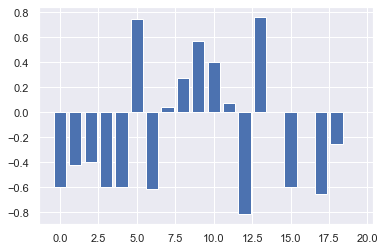

In [1086]:
##### it seems that inevitably, some of these sentences are going to get misclassified.
#I wonder what the mean compound score for the sentences will look like.

test_score_lst = []
for sent in df_sent_dom_topics['original_text'][:20]:
    test_score_lst.append(anakin.polarity_scores(sent)['compound'])

plt.bar(range(0,len(test_score_lst)),test_score_lst)

In [1087]:
#How does this compare to the original full review?

full_test_sent = final_data['original_text'][0]
print(full_test_sent)
print(anakin.polarity_scores(full_test_sent))

Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that supply you with certain kind 

In [1088]:
#The result is that the compound score is overwhelmingly negative for the review as a whole.
#The review is both scathing and sarcastic, so I was not expecting a very clear negative. This is a pleasant surprise.
#I believe the sentiment analyzer should be derive reasonably accurate sentiment scores.


#get compound sentiment score for all sentences
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [1089]:
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994
5,Strategic Gameplay,0.7882,"[play, rule, paradox]","[rather, than, improve, it, and, make, it, pla...",3,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...,0.7506
6,Tactical Gameplay,0.7836,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"unit, battle, faction, army, general, characte...",they rather make ai cheat and brake rules like...,-0.6115
7,Strategic Gameplay,0.7280,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...,0.0397
8,Strategic Gameplay,0.6030,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...,0.2732
9,Strategic Gameplay,0.7882,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...,0.5719


In [1090]:
sentiment_lst = df_sent_dom_topics['compound_sentiment']

pos_lst = [x for x in sentiment_lst if x > 0] #find reasonable cutoffs for positive/negative
neutral_lst = [x for x in sentiment_lst if x == 0] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < 0] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst)) #Find out how many reviews would be classified under pos, neutral, or neg and what percentage of the total dataset are they?

0.5652134340584327
0.14062073359424776
0.2941658323473196


In [1091]:
#Looking for a good cutoff point for sentiment, I started by setting the cutoffs to X > 0, X ==0, and X < 0 to reduce any chances of bias when setting the cutoffs

pos_lst = [x for x in sentiment_lst if x > 0.1] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.1 and x <=0.1] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.1] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.5206152725948848
0.2089742422863384
0.27041048511877674


In [1092]:
pos_lst = [x for x in sentiment_lst if x > 0.2] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.2 and x <=0.2] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.2] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.4900336761627378
0.2664057522526622
0.24356057158459998


In [1093]:
sa_mask = df_sent_dom_topics['dominant_topic']=='Series Authenticity'
sa_df = df_sent_dom_topics[sa_mask]
sa_df[sa_df['compound_sentiment']>0]
list(sa_df['compound_sentiment'])[:10]

[0.0828, 0.6997, 0.2023, 0.3774, 0.0, 0.2732, -0.4404, 0.5106, 0.0772, 0.4215]

In [1094]:
#It seems that setting the cutoffs to 0.1 is a good option.
#This does increase the number of reviews that will be classified as neutral, but the tradeoff is worth it.
#It reduces some bias because we will avoid having reviews that are mostly neutral, but just slightly positive or negative.

perc_dict = {}

for topic in list(topic_dict.values()):
    
    topic_mask = df_sent_dom_topics['dominant_topic']==topic
    topic_df = df_sent_dom_topics[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict

{'Series Authenticity': [0.536, 0.208, 0.257],
 'Characters': [0.451, 0.267, 0.281],
 'Strategic Gameplay': [0.533, 0.209, 0.258],
 'Tactical Gameplay': [0.53, 0.189, 0.281],
 'Performance & Stability': [0.464, 0.206, 0.331]}

In [1095]:
#Let's try this at the document level rather than sentence level, just to see what happens

final_data['compound_sentiment'] = final_data['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [1096]:
#sentiment analysis by review (NOT by sentence)

perc_dict2 = {}

for topic in list(topic_dict.values()):
    
    topic_mask = final_data['dominant_topic']==topic
    topic_df = final_data[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict2[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict2

{'Series Authenticity': [0.769, 0.101, 0.13],
 'Characters': [0.528, 0.182, 0.29],
 'Strategic Gameplay': [0.64, 0.042, 0.318],
 'Tactical Gameplay': [0.681, 0.043, 0.276],
 'Performance & Stability': [0.678, 0.085, 0.237]}

In [1097]:
print("By sentence\n",perc_dict)
print("\nBy review\n",perc_dict2)

By sentence
 {'Series Authenticity': [0.536, 0.208, 0.257], 'Characters': [0.451, 0.267, 0.281], 'Strategic Gameplay': [0.533, 0.209, 0.258], 'Tactical Gameplay': [0.53, 0.189, 0.281], 'Performance & Stability': [0.464, 0.206, 0.331]}

By review
 {'Series Authenticity': [0.769, 0.101, 0.13], 'Characters': [0.528, 0.182, 0.29], 'Strategic Gameplay': [0.64, 0.042, 0.318], 'Tactical Gameplay': [0.681, 0.043, 0.276], 'Performance & Stability': [0.678, 0.085, 0.237]}


In [1098]:
#going by document and aggregating scores by topics that exist in each document

final_data.head(2)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,compound_sentiment
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4715,"['ton', 'diplomacy', 'joke', 'military_access'...",85,"['guess', 'artillery', 'chain', 'siege', 'sent...",57,"unit, battle, faction, army, general, characte...",-0.9892
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",0.0000


In [1099]:
#parse reviews into sentences and run topic model to get results for each review
test_sentiment_docs = list(final_data['original_text'][:50])

test_sentiment_docs = list(final_data['original_text'][:50])
test_parse_lst = []

test_parse_lst = [parse_sent_tokenize(x) for x in test_sentiment_docs]

test_parse_lst=[remove_punc(x) for x in test_parse_lst]  #for each review, remove punctuation from each sentence (remove_punc takes lists of sentences)

test_parse_lst = [[y.split() for y in x] for x in test_parse_lst]   #split each sentence into a list of tokens (a list of tokens represents a sentence)

#re-define stopwords so we can create n-grams properly
en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']

test_parse_lst=[[remove_stopwords(y) for y in x] for x in test_parse_lst]  #remove stopwords, iterating over each word in each list of tokens for each list of sentences

test_parse_lst=make_trigrams(test_parse_lst) #make 3grams from the list of lists of tokens

en_stopwords.extend(['one','two','three','thing','bit','total_war','time']) #after making bigrams, removing numbers and some other common terms should reduce noise

test_parse_lst=[[remove_stopwords(y) for y in x] for x in test_parse_lst]  #remove stopwords one more time with new extended list of stopwords

test_3grams = [[spacy_lemma(y) for y in x] for x in test_parse_lst] #spacy_lemma takes lists of tokens, and will ignore n-grams

test_fin = [x for x in test_3grams]

#test_fin = [[[z for z in y if z !=''] for y in x] for x in test_3grams] #removes the blanks left by spacy_lemma() for each sentence in each review   
#do this and the next 2 lines only after putting together sentences and their corresponding tokens

#test_fin = [[y for y in x if len(y)>=2] for x in test_fin] #remove any sentence token lists that have 0 or 1 tokens, because they are likely to be classified wrongly, as established previously

#test_fin = [x for x in test_fin if len(x)>=2] #remove any review token lists that have 0 or 1 tokens 
    
#print(test_parse_lst)  # use this when testing the output as you go

print(test_fin) #Note that some sentences will have 0 tokens and that's ok -- they are supposed to, because the token prior to that was not a noun or n-gram.


In [1100]:
#The output above is a list of lists of lists. A bit complex, but convenient.
#It is a list of tokens for each sentence for each review, which will be used for topic assignment by the LDA model

sent_by_review_df = pd.DataFrame()

sent_by_review_df['original_text'] = final_data['original_text']

sent_by_review_df['sent_list'] = sent_by_review_df['original_text'].map(lambda x: parse_sent_tokenize(x))

sent_by_review_df['sent_list'] = sent_by_review_df['sent_list'].map(lambda x:remove_punc(x))

In [1101]:
token_lst = [[y.split() for y in x] for x in sent_by_review_df['sent_list']]

#re-define stopwords so we can create n-grams properly
en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

token_lst = [[remove_stopwords(y) for y in x] for x in token_lst]  #remove stopwords, iterating over each word in each list of tokens for each list of sentences

token_lst = make_trigrams(token_lst) #make 3grams from the list of lists of tokens

en_stopwords.extend(['one','two','three','thing','bit','total_war','time']) #after making bigrams, removing numbers and some other common terms should reduce noise

token_lst = [[remove_stopwords(y) for y in x] for x in token_lst]  #remove stopwords one more time with new extended list of stopwords

text_3grams = [[spacy_lemma(y) for y in x] for x in token_lst] #spacy_lemma takes lists of tokens, and will ignore n-grams. Leaves behind blanks; at this point this is preferred

sent_by_review_df['token_list'] = text_3grams

In [1102]:
sent_by_review_df.head()

,original_text,sent_list,token_list
0,Well for me game still tons of work. i like it...,"[well for me game still tons of work, like it ...","[[ton, ], [], [], [diplomacy], [joke], [work],..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"[pursued lu bu, now am lu bu]","[[, lu_bu], [lu_bu]]"
2,Absolutely great game. \nAll the new diplomacy...,"[absolutely great game, all the new diplomacy ...","[[], [, diplomacy_options, depth], [unit_varie..."
3,A fine blend of Warhammer I/II: Total War and ...,"[fine blend of warhammer, iii total war and sh...","[[, blend, warhammer], [shogun_two], [, , love..."
4,Innovative Total Game that has lots of persona...,[innovative total game that has lots of person...,"[[, , lot, personality, , , diplomacy, idea], ..."


In [1103]:
big_sent_lst2 =[] #For storing ALL sentences in the dataset. Another list will help label which reviews they came from

review_index_lst = [] #for storing all index numbers for each sentence so we can identify which reviews they belong to and thus group scores by topics and reviews

sent_df2 = pd.DataFrame() #For visualisation of sentence transformations and saving of data

review_count = 0
for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst2.extend(sent_tokens)
    
    review_count+=1
    review_num_lst = [str(review_count)] * len(sent_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
    review_index_lst.extend(review_num_lst)

sent_df2['sentences'] = big_sent_lst2
sent_df2['review_number'] = review_index_lst
sent_df2.head()

,sentences,review_number
0,well for me game still tons of work,1
1,like it but just cant recommend,1
2,1,1
3,diplomacy,1
4,it is joke,1


In [1104]:
sent_df2['token_sentences'] = [x.split() for x in big_sent_lst2]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

sent_df2['sents_unstopped'] = sent_df2['token_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['3gram_sentences'] = make_trigrams(sent_df2['sents_unstopped'])
sent_df2['3gram_sentences'] = sent_df2['3gram_sentences'].map(lambda x: spacy_lemma(x))

en_stopwords.extend(['one','two','three','thing','bit','total_war','time']) #after making bigrams, removing numbers should reduce noise

sent_df2['3gram_sentences_clean'] = sent_df2['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['num_tokens'] = sent_df2['3gram_sentences_clean'].map(lambda x: len(x))

In [1105]:
len(sent_df2)

16735

In [1106]:
sent_df2.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work,1,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton],1
1,like it but just cant recommend,1,"[like, it, but, just, cant, recommend]",[recommend],[],[],0
2,1,1,[1],[one],[],[],0
3,diplomacy,1,[diplomacy],[diplomacy],[diplomacy],[diplomacy],1
4,it is joke,1,"[it, is, joke]",[joke],[joke],[joke],1
5,nothing works,1,"[nothing, works]",[works],[work],[work],1
6,you have trade and military access with cao ca...,1,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
7,you are too small,1,"[you, are, too, small]",[small],[],[],0
8,well you will get war declaration each turn in...,1,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
9,its ok if you are at war with more factions th...,1,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3


In [1107]:
ultimate_sent_df = sent_df2[sent_df2['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df2)-len(ultimate_sent_df))/len(sent_df2)
print(dropped_rows)
print(len(ultimate_sent_df))   #WHY is the length of this df longer than the previous one although the code is the same?

0.3434717657603824
10987


In [1108]:
ultimate_sent_df.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,you have trade and military access with cao ca...,1,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
1,well you will get war declaration each turn in...,1,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
2,its ok if you are at war with more factions th...,1,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3
3,oh and if you are too big guess what still war...,1,"[oh, and, if, you, are, too, big, guess, what,...","[oh, big, guess, war, turn]","[, , guess, war, turn]","[guess, war, turn]",3
4,mean did they even test this diplomacy war dec...,1,"[mean, did, they, even, test, this, diplomacy,...","[mean, test, diplomacy, war, declaration, run]","[, test, diplomacy, war, declaration, ]","[test, diplomacy, war, declaration]",4
5,rather than improve it and make it play by the...,1,"[rather, than, improve, it, and, make, it, pla...","[improve, play, rules, paradox]","[, play, rule, paradox]","[play, rule, paradox]",3
6,they rather make ai cheat and brake rules like...,1,"[they, rather, make, ai, cheat, and, brake, ru...","[ai, cheat, brake, rules, having, shadow, inco...","[, , brake, rule, , shadow, income, , punishme...","[brake, rule, shadow, income, punishment, pact]",6
7,like in eu4 where your stability drops if you ...,1,"[like, in, eu4, where, your, stability, drops,...","[eu4, stability, drops, declare, war, reason, ...","[, stability, , declare_war, reason, attack, e...","[stability, declare_war, reason, attack, enemy...",6
8,you have about chains of troop buildings that ...,1,"[you, have, about, chains, of, troop, building...","[chains, troop, buildings, supply, certain, ki...","[chain, troop, building, , , , troop]","[chain, troop, building, troop]",4
9,wanna have artillery ok just build artillery s...,1,"[wanna, have, artillery, ok, just, build, arti...","[wanna, artillery, ok, build, artillery, school]","[, artillery, , , artillery, school]","[artillery, artillery, school]",3


In [1109]:
ultimate_sent_df.select_dtypes(include='O').describe()

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
count,10987,10987,10987,10987,10987,10987
unique,10966,3036,10965,10924,10894,10683
top,best total war since shogun 2,1979,"[best, total, war, since, shogun, 2]","[best, total, war, shogun, two]","[best_total_war, shogun_two]","[best_total_war, series]"
freq,5,56,5,12,12,13


In [1110]:
ultimate_sent_df.isnull().sum()

sentences                0
review_number            0
token_sentences          0
sents_unstopped          0
3gram_sentences          0
3gram_sentences_clean    0
num_tokens               0
dtype: int64

In [1111]:
ultimate_sent_df.describe()

,num_tokens
count,10987.000000
mean,4.197324
std,2.907366
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,40.000000


In [1112]:
#initialise model

#reload data for model 
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/model2/model2.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open

In [1113]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.023*"three_kingdoms" + 0.023*"series" + 0.021*"fan" + 0.020*"diplomacy" + 0.020*"battle" + 0.018*"love" + 0.018*"best_total_war" + 0.017*"campaign" + 0.014*"total_war_games" + 0.014*"fun" + 0.014*"character" + 0.014*"shogun" + 0.014*"play" + 0.011*"title" + 0.009*"gameplay"')

(1, '0.025*"china" + 0.021*"war" + 0.021*"cao_cao" + 0.019*"lu_bu" + 0.016*"liu_bei" + 0.016*"yuan_shao" + 0.014*"army" + 0.011*"character" + 0.011*"man" + 0.010*"emperor" + 0.010*"warlord" + 0.010*"friend" + 0.010*"history" + 0.009*"faction" + 0.009*"sun_jian"')

(2, '0.037*"faction" + 0.027*"army" + 0.024*"diplomacy" + 0.016*"vassal" + 0.015*"war" + 0.014*"player" + 0.013*"people" + 0.012*"way" + 0.011*"city" + 0.011*"problem" + 0.011*"campaign" + 0.010*"option" + 0.009*"spy" + 0.009*"three_kingdoms" + 0.009*"review"')

(3, '0.053*"unit" + 0.035*"battle" + 0.026*"faction" + 0.023*"army" + 0.022*"general" + 0.022*"character" + 0.013*"diplomacy" + 0.013*"campaign" + 0.011*"hero" + 0.010*"building" + 0.010*

In [1114]:
documents = list(ultimate_sent_df['3gram_sentences_clean'])
dictionary = gensim.corpora.Dictionary(documents)

#disregard previous warning to give exactly the same dictionary -- it just needs to have the same filter_extremes parameters and the same preprocessing for the input text
dictionary.filter_extremes(no_below = 5,no_above=0.5)     

corpus = [dictionary.doc2bow(text) for text in documents]

In [1115]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [1116]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Series Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'Performance & Stability',
             }

#created a dictionary so I can show topic names instead of numbers

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(ultimate_sent_df[['sentences','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return sent_topics_df

In [1117]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [1118]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=ultimate_sent_df['num_tokens']
df_sent_dom_topics['review_number']=ultimate_sent_df['review_number'].map(lambda x: int(x))

df_sent_dom_topics = df_sent_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...
2,1,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...
5,1,Strategic Gameplay,0.7882,"[play, rule, paradox]","[rather, than, improve, it, and, make, it, pla...",3,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...
6,1,Tactical Gameplay,0.7836,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"unit, battle, faction, army, general, characte...",they rather make ai cheat and brake rules like...
7,1,Strategic Gameplay,0.7280,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...
8,1,Strategic Gameplay,0.6030,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...
9,1,Strategic Gameplay,0.7882,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...


In [1119]:
max((df_sent_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

3658

In [1120]:
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,1,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994
5,1,Strategic Gameplay,0.7882,"[play, rule, paradox]","[rather, than, improve, it, and, make, it, pla...",3,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...,0.7506
6,1,Tactical Gameplay,0.7836,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"unit, battle, faction, army, general, characte...",they rather make ai cheat and brake rules like...,-0.6115
7,1,Strategic Gameplay,0.7280,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...,0.0397
8,1,Strategic Gameplay,0.6030,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...,0.2732
9,1,Strategic Gameplay,0.7882,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...,0.5719


In [1121]:
df_sent_dom_topics.to_csv('./dataframes/final_agg_sent_topics.csv')

In [1122]:
#try a few ways of aggregating compound sentiment by topic for 1 review

toy_sent_data = df_sent_dom_topics[df_sent_dom_topics['review_number']==1]
toy_sent_data.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,1,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994


In [1123]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].sum()

dominant_topic
Characters            0.4019
Strategic Gameplay    2.4776
Tactical Gameplay    -5.5512
Name: compound_sentiment, dtype: float64

In [1124]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].mean()

dominant_topic
Characters            0.401900
Strategic Gameplay    0.412933
Tactical Gameplay    -0.462600
Name: compound_sentiment, dtype: float64

In [1125]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].median()

dominant_topic
Characters            0.40190
Strategic Gameplay    0.42255
Tactical Gameplay    -0.59940
Name: compound_sentiment, dtype: float64

In [1126]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].count()

dominant_topic
Characters             1
Strategic Gameplay     6
Tactical Gameplay     12
Name: compound_sentiment, dtype: int64

# Deciding on Aggregation

The mean is the least preferred option because it includes outliers, which can skew the data.

Using sum is not much different from the mean, and in fact creates another problem because it doesn't work on the same scale as VADER (floating points from -1.0 to 1.0).

Median should work just fine. It should show a score that reflects the general direction of the sentiment, since it is the middle point in all of the data.

Text(0, 0.5, 'Number of sentences')

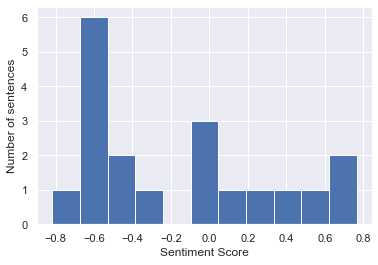

In [1127]:
#Visualise distribution of sentiment scores
plt.hist(toy_sent_data['compound_sentiment'],bins=11) #use odd numbers so the neutral ones have their own bin in the centre
plt.xlabel('Sentiment Score')
plt.ylabel('Number of sentences')

In [1128]:
print("mean:",toy_sent_data['compound_sentiment'].mean())
print("median:",toy_sent_data['compound_sentiment'].median())

mean: -0.14061578947368425
median: -0.25


In [1129]:
#The median is more reflective of the general sentiment of the review's sentences, but the score is not severely negative like the actual review.
#Maybe this problem has a simple solution...

score_lst = [-0.9,-0.1,0,0.1,0.15,0.9]

def sent_score_int(score_lst):
    int_scores = [(-1 if x <-0.1 else (0 if -0.1 <= x <= 0.1 else 1)) for x in score_lst]
    return int_scores

toy_sent_data['int_scores'] = sent_score_int(toy_sent_data['compound_sentiment'])
toy_sent_data.head()

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994,-1
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215,-1
2,1,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019,-1
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994,-1
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994,-1


In [1130]:
#Now, any score that is conclusively negative (x<-0.1) is assigned the value of -1; 0 for neutral (-0.1 < x < 0.1), 1 for positive (x > 0.1)
#he exact score is not important for this model. All we need is whether a review is positive, netural, or negative.

print(topic_dict)

#for key in topic_dict:

topic_df = toy_sent_data[toy_sent_data['dominant_topic'] == topic_dict['3']]

review_dict= {}

score_lst = list(topic_df['int_scores'])

rev_topic_pos = score_lst.count(1)/len(score_lst)
rev_topic_neutral = score_lst.count(0)/len(score_lst)
rev_topic_neg = score_lst.count(-1)/len(score_lst)

print("Positive:",rev_topic_pos)
print("Neutral:",rev_topic_neutral)
print("Negative:",rev_topic_neg)

review_scores = [rev_topic_pos, rev_topic_neutral, rev_topic_neg]

mx = max(review_scores)

#assign sentiment rating based on the dominant sentiment for the current topic
if mx == review_scores[0]:
    sentiment = 1

elif mx == review_scores[1]:
    sentiment = 0

else:
    sentiment = -1

review_dict[topic_dict['3']]=sentiment
print(review_dict)

{'0': 'Series Authenticity', '1': 'Characters', '2': 'Strategic Gameplay', '3': 'Tactical Gameplay', '4': 'Performance & Stability'}
Positive: 0.0
Neutral: 0.16666666666666666
Negative: 0.8333333333333334
{'Tactical Gameplay': -1}


In [1131]:
t_dict = {'0':[],
          '1':[],
          '2':[],
          '3':[],
          '4':[]
         }

t_dict['0'].append(1)
t_dict['0'].append(1)
t_dict['0'].append(-1)
t_dict

{'0': [1, 1, -1], '1': [], '2': [], '3': [], '4': []}

In [1132]:
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }
score_dict

{'Series Authenticity': [],
 'Characters': [],
 'Strategic Gameplay': [],
 'Tactical Gameplay': [],
 'Performance & Stability': []}

In [1133]:
#Transform sentiment scores for the larger dataset
df_sent_dom_topics['int_scores'] = sent_score_int(df_sent_dom_topics['compound_sentiment'])
df_sent_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994,-1
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215,-1
2,1,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019,-1
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994,-1
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994,-1


In [1134]:
#Now we do the above for all topics in the whole review... which we will later transplant into a higher-level loop that goes through all reviews one by one in this manner

#define function to find mode
def mode_function2(lst):
    counter = Counter(lst)
    _,val = counter.most_common(1)[0]
    return [x for x,y in counter.items() if y == val]

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }

review_numbers = list(df_sent_dom_topics['review_number'].unique())[:2] #for now we will just take 2 reviews to test this loop

for i in review_numbers: 

    review_mask = df_sent_dom_topics['review_number'] == i
    review_df = df_sent_dom_topics[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            mode_lst = mode_function2(score_lst)

            #rev_topic_pos = score_lst.count(1)/len(score_lst)
            #rev_topic_neutral = score_lst.count(0)/len(score_lst)
            #rev_topic_neg = score_lst.count(-1)/len(score_lst)

            #review_scores = [rev_topic_pos, rev_topic_neutral, rev_topic_neg]
            

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #since sentiment is mixed, assign neutral sentiment value

            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

print(score_dict)

{'Series Authenticity': [0], 'Characters': [1, 0], 'Strategic Gameplay': [1], 'Tactical Gameplay': [-1, -1], 'Performance & Stability': []}


In [1135]:
#verify results(1)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[0]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode()) #used only here for quick verification -- 

dominant_topic       
Characters          0    1
Strategic Gameplay  0    1
Tactical Gameplay   0   -1
Name: int_scores, dtype: int64

In [1136]:
#verify results(2)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[1]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode())

dominant_topic        
Characters           0    0
Series Authenticity  0    0
                     1    1
Tactical Gameplay    0   -1
Name: int_scores, dtype: int64

In [1137]:
#The test results match: 1 pos for Series Authenticity, 1 pos and 1 neutral for Characters, 1 pos for Strategic Gameplay, 2 neg for Tactical Gameplay, no results for Performance & Stability

#now running for all reviews

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }

review_numbers = list(df_sent_dom_topics['review_number'].unique()) #iterates through ALL reviews in the dataset

for i in review_numbers: 

    review_mask = df_sent_dom_topics['review_number'] == i
    review_df = df_sent_dom_topics[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            
            mode_lst = mode_function2(score_lst) 

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #Sentiment is mixed when there are multiple modes, thus assign neutral sentiment value


            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

In [1138]:
final_score_dict = {}
for key in score_dict:
    full_score_lst = score_dict[key]
    
    full_topic_pos = full_score_lst.count(1)/len(full_score_lst)
    full_topic_neutral = full_score_lst.count(0)/len(full_score_lst)
    full_topic_neg = full_score_lst.count(-1)/len(full_score_lst)
    
    full_scores = [round(full_topic_pos,3),round(full_topic_neutral,3),round(full_topic_neg,3)]
    
    final_score_dict[key] = full_scores

final_score_dict #positive, neutral, negative

{'Series Authenticity': [0.537, 0.29, 0.173],
 'Characters': [0.436, 0.339, 0.225],
 'Strategic Gameplay': [0.519, 0.265, 0.216],
 'Tactical Gameplay': [0.55, 0.253, 0.196],
 'Performance & Stability': [0.436, 0.274, 0.291]}

In [1139]:
overall_score_df = pd.DataFrame(final_score_dict).T
#overall_score_df.index = ['Pos','Neutral','Neg']
overall_score_df.columns = ['Pos','Neutral','Neg']
overall_score_df

,Pos,Neutral,Neg
Series Authenticity,0.537,0.290,0.173
Characters,0.436,0.339,0.225
Strategic Gameplay,0.519,0.265,0.216
Tactical Gameplay,0.550,0.253,0.196
Performance & Stability,0.436,0.274,0.291


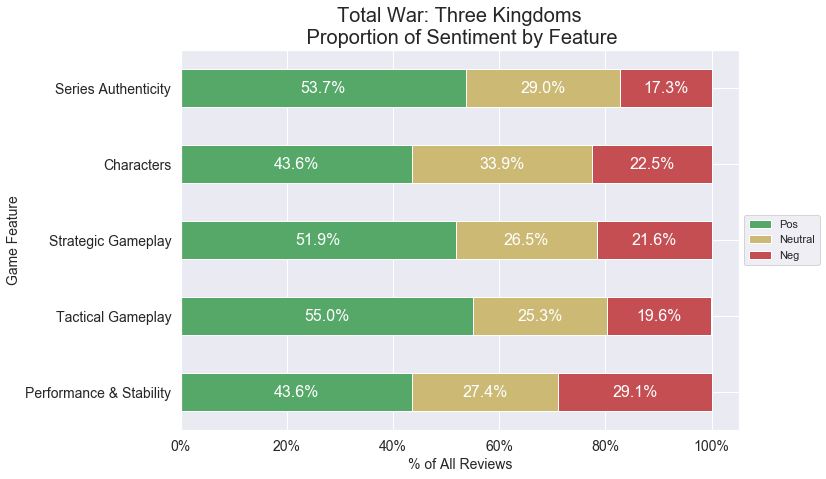

In [1140]:
#plot visualisation for the results of the 3rd attempt at aggregation
ax = overall_score_df.plot(kind='barh',stacked=True,figsize=(10,7),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

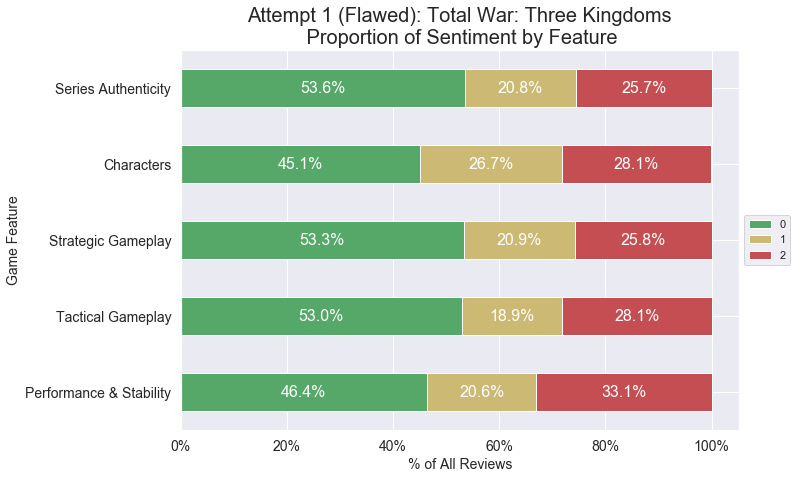

In [1141]:
#comparison to other methods

ax = pd.DataFrame(perc_dict).T.plot(kind='barh',stacked=True,figsize=(10,7),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Attempt 1 (Flawed): Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

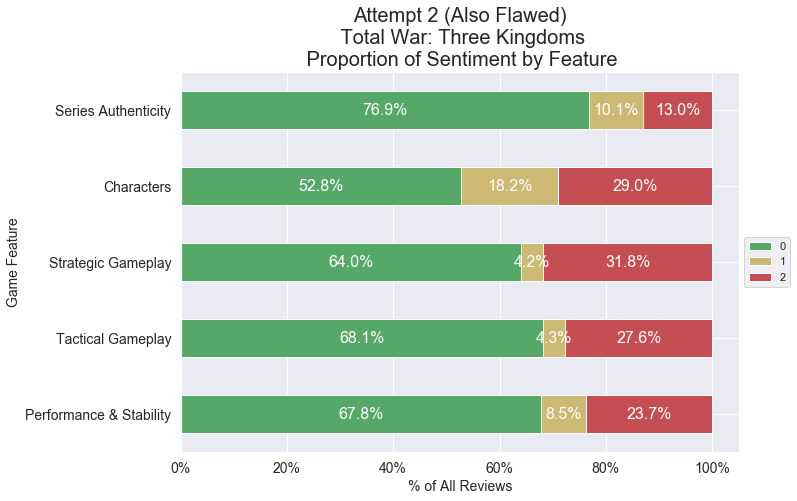

In [1142]:
#comparison to other methods -- percentage_dict2, from the by-sentence approach 

ax = pd.DataFrame(perc_dict2).T.plot(kind='barh',stacked=True,figsize=(10,7),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Attempt 2 (Also Flawed)\n Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

In [1143]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Roundup on Sentiment Analysis

The 3rd attempt at labelling reviews and sentiments seems to output results very similar to the 1st attempt, but getting the 1st attempt's results was more akin to random chance.

The 3rd attempt's aggregation process is more rigorous and more closely follows the way a human would identify topics and score sentiments for each review.

Also, I found that including a clause to assign neutral sentiment values to mixed reviews (multiple dominating sentiments should logically indicate mixed sentiment) changed the results to be less in favour of Positive sentiment, more in favour of Neural, and having little effect on Negative sentiment.

The 3rd attempt has a more rigorous mathematical and logical process backing it, and I believe in it more than I do in any previous attempt.

In [1144]:
overall_score_df[['Pos','Neutral','Neg']]

,Pos,Neutral,Neg
Series Authenticity,0.537,0.290,0.173
Characters,0.436,0.339,0.225
Strategic Gameplay,0.519,0.265,0.216
Tactical Gameplay,0.550,0.253,0.196
Performance & Stability,0.436,0.274,0.291


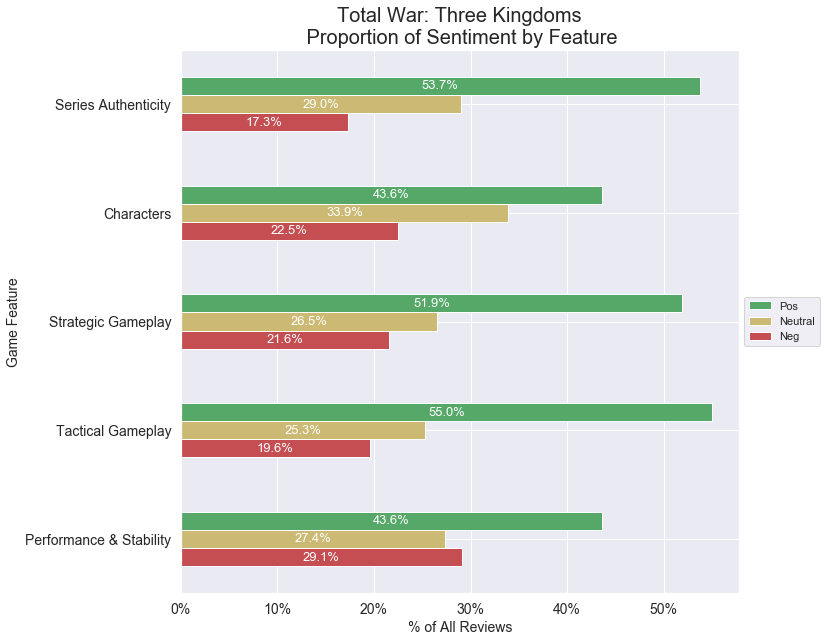

In [1145]:
#Final individual plots
ax = overall_score_df.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=13,color='w')

In [1162]:
final_data.head(2)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,compound_sentiment
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4715,"['ton', 'diplomacy', 'joke', 'military_access'...",85,"['guess', 'artillery', 'chain', 'siege', 'sent...",57,"unit, battle, faction, army, general, characte...",-0.9892
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",0.0000


In [1340]:
# 4th and final attempt

#Found a better sentence tokenizer
#SpaCy sentence tokenizer breaks sentences at strange intervals
#Syntok seems to tokenize sentences quite well without breaking them up into parts
#https://github.com/fnl/syntok/blob/master/README.rst

import syntok.segmenter as segmenter

reviews = final_data['original_text'][:1]

dl = []

for i in range(len(reviews)):
    document = reviews[i]

    for paragraph in segmenter.process(document):
        pl = []
        sent_ct = 0
        for sentence in paragraph:
            sent_ct+=1
            sl = []
            for token in sentence:
                # roughly reproduce the input,
                # except for hyphenated word-breaks
                # and replacing "n't" contractions with "not",
                # separating tokens by single spaces
                sl.append(token.value)
            sl = [' '.join(w for w in sl)]

            print(str(sent_ct)+':',sl)  # print one sentence per line
        
            pl.append(sl)
        
        print("\n")  # separate paragraphs with newlines
        
        dl.append(pl)
        
    print(dl)

1: ['Well for me game still tons of work . i like it but just cant recommend .']
2: ['1 . Diplomacy .']
3: ['It is joke .']
4: ['Nothing works .']
5: ['You have trade and military access with CAO CAO ?']
6: ['War declaration next turn .']
7: ['You are too small ? well you will get war declaration each turn .']
8: ['In this game its ok if you are at war with more factions than you have armies .']
9: ['Oh and if you are too big ? guess what ? still war each turn . i mean did they even test this diplomacy ?']
10: ['3 war declaration in t run ? for nothing ? i am total war veteran and i can see what they have done with AI .']
11: ['Rather than improve it and make it play by the rules like paradox have done .']
12: ['They rather make AI cheat and brake rules like having , , shadow income " .']
13: ['Or have some sort of punishment for breaking pacts .']
14: ['Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you .']
15: ['2 

In [1390]:
def syntok_sent_tokenizer(reviews,expcon=True, expconbreak=False):
    
    orig_sents = []

    review_tokens = []
    
    full_review_tokens = []
    
    review_index_lst = [] #for identifying review number

    for i in range(len(reviews)):
        document = reviews[i]
        orig_doc = document

        document = parse(document)
        
        if expcon==True:
            doc_prior = document
            document = expandContractions(document) #put this in an if-else to demonstrate that expandContractions is causing sentences to be made into paragraphs
            
            if expconbreak==True:
                #print("Original\n\n",orig_doc,"\n\n")
                print("Prior to expandContractions\n\n",doc_prior,"\n\n")
                break
            
        else:
            pass

        document = [word for word in document.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')]
        document = ' '.join(word for word in document)

        for doc in segmenter.process(document):
            review_tokens = []
            
            for sentence in doc:
                sl = []
                
                for token in sentence:
                    
                    sl.append(token.value)
                
                sl = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ' '.join(word for word in sl)) #remove whitespace only before punctuation at end of sentence

                review_tokens.append(sl)
                
            review_num_lst = [str(i)] * len(review_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
            review_index_lst.extend(review_num_lst)
            
        full_review_tokens.extend(review_tokens) #join new sent as str to end of this list
        
    return full_review_tokens, review_index_lst

In [1392]:
syntok_sent_tokenizer(final_data['original_text'][:2])

(['well for me game still tons of work. like it but just cant recommend.',
  '1. diplomacy it is joke. nothing works. you have trade and military access with cao cao war declaration next turn. you are too small well you will get war declaration each turn in this game its ok if you are at war with more factions than you have armies. oh and if you are too big guess what still war each turn. mean did they even test this diplomacy war declaration in run for nothing? i am total war veteran and can see what they have done with ai. rather than improve it and make it play by the rules like paradox have done. they rather make ai cheat and brake rules like having , , shadow income" . or have some sort of punishment for breaking pacts. like in eu4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.',
  '2. troops. in twh ( also in rome ) all is simple. you have about chains of troop buildings that supply you with certain kind of troops. wa

In [1393]:
#Happy accident! The text is being returned as paragraphs. I was looking for a tool that could do this, but couldn't find one.
#Originally it only returned single sentences as separated by '\n'.
#After some inspection, it turns out that expandContractions is the one causing the sentences to become paragraphs

syntok_sent_tokenizer(final_data['original_text'][:1],expcon=False)

(['Well for me game still tons of work. like it but just cant recommend.',
  '1. Diplomacy It is joke.',
  'Nothing works.',
  'You have trade and military access with CAO CAO War declaration next turn.',
  'You are too small well you will get war declaration each turn In this game its ok if you are at war with more factions than you have armies.',
  'Oh and if you are too big guess what still war each turn. mean did they even test this diplomacy war declaration in run for nothing? i am total war veteran and can see what they have done with AI.',
  'Rather than improve it and make it play by the rules like paradox have done.',
  'They rather make AI cheat and brake rules like having , , shadow income" .',
  'Or have some sort of punishment for breaking pacts.',
  'Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.',
  '2. Troops.',
  'In TWH ( also in Rome ) all is simple.',
  'You have about chains of troop buildin

In [1394]:
#testing on more than 1 review
syntok_sent_tokenizer(final_data['original_text'][:1],expcon=True,expconbreak=True)

Prior to expandContractions

 Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that

([], [])

In [1412]:
#Further investigation may be warranted, but in any case it is a positive unintended effect. It does what I need it to do.
#It is also generally a better package for sentence tokenisation than SpaCy.

syntok_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

reviews = final_data['original_text']

syntok_sent_lst, review_index_lst = syntok_sent_tokenizer(reviews)

syntok_df['sentences'] = syntok_sent_lst
syntok_df['review_number'] = review_index_lst

print(len(syntok_df))
print(abs(len(syntok_df)-len(final_data)))
print(abs(len(syntok_df)-len(final_data))/len(final_data))
syntok_df.head()

4301
642
0.17545777534845586


,sentences,review_number
0,well for me game still tons of work. like it b...,0
1,1. diplomacy it is joke. nothing works. you ha...,0
2,2. troops. in twh ( also in rome ) all is simp...,0
3,3. city building. tons of buildings that you w...,0
4,pursued lu bu. now am lu bu.,1


In [1413]:
#Only gained 642 (17%) more rows (as compared to original number of rows in of dataset) as new lines.
#Result is a little disappointing, but then again most reviews are very short, about 1 paragraph long.
#This result is within expectations. Actually, this might be better, since for every paragraph we must find a dominant topic and corresponding sentiment anyway. 
#This would be less biased than going purely by the whole review. The classification of sentences and the sentiment analysis will be more accurate!

syntok_df['clean_sentences'] = remove_punc(syntok_sent_lst)
syntok_df['token_sentences'] = [x.split() for x in syntok_df['clean_sentences']]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

syntok_df['sents_unstopped'] = syntok_df['token_sentences'].map(lambda x: remove_stopwords(x))
syntok_df['3gram_sentences'] = make_trigrams(syntok_df['sents_unstopped'])

en_stopwords.extend(['one','two','three','thing','bit','total_war','time']) #after making bigrams, removing numbers should reduce noise

syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences'].map(lambda x: spacy_lemma(x))

In [1415]:
syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences_clean'].map(lambda x: [y for y in x if y != ''])
syntok_df['num_tokens'] = syntok_df['3gram_sentences_clean'].map(lambda x: len(x))
syntok_df.head(5)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work. like it b...,0,well for me game still tons of work like it bu...,"[well, for, me, game, still, tons, of, work, l...","[tons, work, recommend]","[tons, work, recommend]",[ton],1
1,1. diplomacy it is joke. nothing works. you ha...,0,1 diplomacy it is joke nothing works you have ...,"[1, diplomacy, it, is, joke, nothing, works, y...","[one, diplomacy, joke, works, trade, military,...","[one, diplomacy, joke, works, trade, military_...","[diplomacy, joke, military_access, cao_cao, wa...",38
2,2. troops. in twh ( also in rome ) all is simp...,0,2 troops in twh also in rome all is simple y...,"[2, troops, in, twh, also, in, rome, all, is, ...","[two, troops, twh, rome, simple, chains, troop...","[two, troops, twh, rome, simple, chains, troop...","[troop, chain, troop, building, kind, troop, a...",26
3,3. city building. tons of buildings that you w...,0,3 city building tons of buildings that you won...,"[3, city, building, tons, of, buildings, that,...","[three, city, building, tons, buildings, wont,...","[three, city, building, tons, buildings, wont,...","[city, building, ton, building, buff, task, bu...",21
4,pursued lu bu. now am lu bu.,1,pursued lu bu now am lu bu,"[pursued, lu, bu, now, am, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[lu_bu, lu_bu]",2


In [1494]:
syntok_df['num_tokens'].describe()

count    4301.000000
mean       12.502209
std        20.953488
min         0.000000
25%         2.000000
50%         5.000000
75%        14.000000
max       289.000000
Name: num_tokens, dtype: float64

In [1416]:
final_syntok_df = syntok_df[syntok_df['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(final_syntok_df)-len(syntok_df))/len(syntok_df)
print(dropped_rows)
print(len(final_syntok_df))

0.13485235991629854
3721


In [1417]:
final_syntok_df.head(10)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,1. diplomacy it is joke. nothing works. you ha...,0,1 diplomacy it is joke nothing works you have ...,"[1, diplomacy, it, is, joke, nothing, works, y...","[one, diplomacy, joke, works, trade, military,...","[one, diplomacy, joke, works, trade, military_...","[diplomacy, joke, military_access, cao_cao, wa...",38
1,2. troops. in twh ( also in rome ) all is simp...,0,2 troops in twh also in rome all is simple y...,"[2, troops, in, twh, also, in, rome, all, is, ...","[two, troops, twh, rome, simple, chains, troop...","[two, troops, twh, rome, simple, chains, troop...","[troop, chain, troop, building, kind, troop, a...",26
2,3. city building. tons of buildings that you w...,0,3 city building tons of buildings that you won...,"[3, city, building, tons, of, buildings, that,...","[three, city, building, tons, buildings, wont,...","[three, city, building, tons, buildings, wont,...","[city, building, ton, building, buff, task, bu...",21
3,pursued lu bu. now am lu bu.,1,pursued lu bu now am lu bu,"[pursued, lu, bu, now, am, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[lu_bu, lu_bu]",2
4,absolutely great game. all the new diplomacy o...,2,absolutely great game all the new diplomacy op...,"[absolutely, great, game, all, the, new, diplo...","[absolutely, new, diplomacy, options, depth, u...","[absolutely, new, diplomacy_options, depth, un...","[diplomacy_options, depth, unit_variety, warha...",11
5,fine blend of warhammer i/ii : total war and s...,3,fine blend of warhammer iii total war and sho...,"[fine, blend, of, warhammer, iii, total, war, ...","[fine, blend, warhammer, three, total, war, sh...","[fine, blend, warhammer_three, total_war, shog...","[blend, warhammer_three, total_war, shogun_two...",9
6,"+ unit formations , fire arrows , etc. make tr...",3,unit formations fire arrows etc make triump...,"[unit, formations, fire, arrows, etc, make, tr...","[unit, formations, arrows, triumphant, return]","[unit, formations, arrows, triumphant, return]","[unit, formation, arrow, triumphant, return]",5
7,+ looks beautiful [ h1 ] cons [ /h1 ] - less v...,3,looks beautiful h1 cons h1 less variable...,"[looks, beautiful, h1, cons, h1, less, variabl...","[looks, beautiful, h1, cons, h1, variable, bat...","[looks_beautiful, h1, cons, h1, variable, batt...","[looks_beautiful, con, battle, character, port...",8
8,innovative total game that has lots of persona...,4,innovative total game that has lots of persona...,"[innovative, total, game, that, has, lots, of,...","[innovative, total, lots, personality, brings,...","[innovative, total, lots, personality, brings,...","[lot, personality, diplomacy, idea, combat, bi...",14
9,masterpiece! it is see lots better an improvem...,5,masterpiece it is see lots better an improveme...,"[masterpiece, it, is, see, lots, better, an, i...","[masterpiece, lots, improvements, features, qu...","[masterpiece, lots, improvements, features, qu...","[masterpiece, lot, improvement, quality, desig...",25


In [1426]:
documents = list(final_syntok_df['3gram_sentences_clean'])
dictionary = gensim.corpora.Dictionary(documents)

#disregard previous warning to give exactly the same dictionary -- it just needs to have the same filter_extremes parameters and the same preprocessing for the input text
dictionary.filter_extremes(no_below = 5,no_above=0.5)     

corpus = [dictionary.doc2bow(text) for text in documents]

In [1427]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Content & Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'UI, Performance, Stability',
             }

#created a dictionary so I can show topic names instead of numbers

def format_topics_sentences(df,ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(df[['sentences','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return sent_topics_df

In [1428]:
#generate dataframe
df_topic_syntok_keywords = format_topics_sentences(final_syntok_df,ldamodel=lda_model, corpus=corpus, documents=documents)

In [1430]:
# Format dataframe
syntok_dom_topics = df_topic_syntok_keywords.reset_index()

syntok_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

syntok_dom_topics['num_tokens']=final_syntok_df['num_tokens']
syntok_dom_topics['review_number']=final_syntok_df['review_number'].map(lambda x: int(x))

syntok_dom_topics = syntok_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,0,Tactical Gameplay,0.5171,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"unit, battle, faction, army, general, characte...",1. diplomacy it is joke. nothing works. you ha...
1,0,Tactical Gameplay,0.5452,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...
2,0,Strategic Gameplay,0.5152,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"faction, army, diplomacy, vassal, war, player,...",3. city building. tons of buildings that you w...
3,1,Tactical Gameplay,0.6944,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"unit, battle, faction, army, general, characte...",pursued lu bu. now am lu bu.
4,2,Content & Authenticity,0.5761,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...
5,3,Content & Authenticity,0.5284,"[blend, warhammer_three, total_war, shogun_two...","[fine, blend, of, warhammer, iii, total, war, ...",9,"three_kingdoms, series, fan, diplomacy, battle...",fine blend of warhammer i/ii : total war and s...
6,3,Content & Authenticity,0.8592,"[unit, formation, arrow, triumphant, return]","[unit, formations, fire, arrows, etc, make, tr...",5,"three_kingdoms, series, fan, diplomacy, battle...","+ unit formations , fire arrows , etc. make tr..."
7,3,Content & Authenticity,0.7162,"[looks_beautiful, con, battle, character, port...","[looks, beautiful, h1, cons, h1, less, variabl...",8,"three_kingdoms, series, fan, diplomacy, battle...",+ looks beautiful [ h1 ] cons [ /h1 ] - less v...
8,4,Tactical Gameplay,0.4343,"[lot, personality, diplomacy, idea, combat, bi...","[innovative, total, game, that, has, lots, of,...",14,"unit, battle, faction, army, general, characte...",innovative total game that has lots of persona...
9,5,Content & Authenticity,0.4738,"[masterpiece, lot, improvement, quality, desig...","[masterpiece, it, is, see, lots, better, an, i...",25,"three_kingdoms, series, fan, diplomacy, battle...",masterpiece! it is see lots better an improvem...


In [1432]:
max((syntok_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

3657

In [1448]:
syntok_dom_topics['compound_sentiment'] = syntok_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
syntok_dom_topics['int_scores']=sent_score_int(syntok_dom_topics['compound_sentiment'])
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,0,Tactical Gameplay,0.5171,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"unit, battle, faction, army, general, characte...",1. diplomacy it is joke. nothing works. you ha...,-0.9541,-1
1,0,Tactical Gameplay,0.5452,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...,-0.1280,-1
2,0,Strategic Gameplay,0.5152,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"faction, army, diplomacy, vassal, war, player,...",3. city building. tons of buildings that you w...,-0.7448,-1
3,1,Tactical Gameplay,0.6944,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"unit, battle, faction, army, general, characte...",pursued lu bu. now am lu bu.,0.0000,0
4,2,Content & Authenticity,0.5761,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...,0.8519,1
5,3,Content & Authenticity,0.5284,"[blend, warhammer_three, total_war, shogun_two...","[fine, blend, of, warhammer, iii, total, war, ...",9,"three_kingdoms, series, fan, diplomacy, battle...",fine blend of warhammer i/ii : total war and s...,0.4019,1
6,3,Content & Authenticity,0.8592,"[unit, formation, arrow, triumphant, return]","[unit, formations, fire, arrows, etc, make, tr...",5,"three_kingdoms, series, fan, diplomacy, battle...","+ unit formations , fire arrows , etc. make tr...",0.2500,1
7,3,Content & Authenticity,0.7162,"[looks_beautiful, con, battle, character, port...","[looks, beautiful, h1, cons, h1, less, variabl...",8,"three_kingdoms, series, fan, diplomacy, battle...",+ looks beautiful [ h1 ] cons [ /h1 ] - less v...,0.3774,1
8,4,Tactical Gameplay,0.4343,"[lot, personality, diplomacy, idea, combat, bi...","[innovative, total, game, that, has, lots, of,...",14,"unit, battle, faction, army, general, characte...",innovative total game that has lots of persona...,-0.0770,0
9,5,Content & Authenticity,0.4738,"[masterpiece, lot, improvement, quality, desig...","[masterpiece, it, is, see, lots, better, an, i...",25,"three_kingdoms, series, fan, diplomacy, battle...",masterpiece! it is see lots better an improvem...,0.9797,1


In [1514]:
syntok_plot_df_1 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=5]
syntok_plot_df_2 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=2]

In [1515]:
#The test results match: 1 pos for Series Authenticity, 1 pos and 1 neutral for Characters, 1 pos for Strategic Gameplay, 2 neg for Tactical Gameplay, no results for Performance & Stability

#now running for all reviews

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }

review_numbers = list(syntok_plot_df_1['review_number'].unique()) #iterates through ALL reviews in the dataset

for i in review_numbers: 

    review_mask = syntok_plot_df_1['review_number'] == i
    review_df = syntok_plot_df_1[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            
            mode_lst = mode_function2(score_lst) 

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #Sentiment is mixed when there are multiple modes, thus assign neutral sentiment value


            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

In [1516]:
final_score_dict = {}
for key in score_dict:
    full_score_lst = score_dict[key]
    
    full_topic_pos = full_score_lst.count(1)/len(full_score_lst)
    full_topic_neutral = full_score_lst.count(0)/len(full_score_lst)
    full_topic_neg = full_score_lst.count(-1)/len(full_score_lst)
    
    full_scores = [round(full_topic_pos,3),round(full_topic_neutral,3),round(full_topic_neg,3)]
    
    final_score_dict[key] = full_scores

final_score_dict #positive, neutral, negative

{'Content & Authenticity': [0.783, 0.052, 0.165],
 'Characters': [0.566, 0.094, 0.34],
 'Strategic Gameplay': [0.603, 0.047, 0.349],
 'Tactical Gameplay': [0.73, 0.067, 0.202],
 'UI, Performance, Stability': [0.753, 0.052, 0.196]}

In [1517]:
syntok_score_df_1 = pd.DataFrame(final_score_dict).T
#overall_score_df_1.index = ['Pos','Neutral','Neg']
syntok_score_df_1.columns = ['Pos','Neutral','Neg']
syntok_score_df_1

,Pos,Neutral,Neg
Content & Authenticity,0.783,0.052,0.165
Characters,0.566,0.094,0.340
Strategic Gameplay,0.603,0.047,0.349
Tactical Gameplay,0.730,0.067,0.202
"UI, Performance, Stability",0.753,0.052,0.196


In [1518]:
#The test results match: 1 pos for Series Authenticity, 1 pos and 1 neutral for Characters, 1 pos for Strategic Gameplay, 2 neg for Tactical Gameplay, no results for Performance & Stability

#now running for all reviews

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }

review_numbers = list(syntok_plot_df_2['review_number'].unique()) #iterates through ALL reviews in the dataset

for i in review_numbers: 

    review_mask = syntok_plot_df_2['review_number'] == i
    review_df = syntok_plot_df_2[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            
            mode_lst = mode_function2(score_lst) 

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #Sentiment is mixed when there are multiple modes, thus assign neutral sentiment value


            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

In [1519]:
final_score_dict = {}
for key in score_dict:
    full_score_lst = score_dict[key]
    
    full_topic_pos = full_score_lst.count(1)/len(full_score_lst)
    full_topic_neutral = full_score_lst.count(0)/len(full_score_lst)
    full_topic_neg = full_score_lst.count(-1)/len(full_score_lst)
    
    full_scores = [round(full_topic_pos,3),round(full_topic_neutral,3),round(full_topic_neg,3)]
    
    final_score_dict[key] = full_scores

final_score_dict #positive, neutral, negative

{'Content & Authenticity': [0.742, 0.099, 0.159],
 'Characters': [0.54, 0.166, 0.294],
 'Strategic Gameplay': [0.551, 0.118, 0.331],
 'Tactical Gameplay': [0.713, 0.094, 0.193],
 'UI, Performance, Stability': [0.689, 0.112, 0.199]}

In [1520]:
syntok_score_df_2 = pd.DataFrame(final_score_dict).T
#overall_score_df_2.index = ['Pos','Neutral','Neg']
syntok_score_df_2.columns = ['Pos','Neutral','Neg']
syntok_score_df_2

,Pos,Neutral,Neg
Content & Authenticity,0.742,0.099,0.159
Characters,0.540,0.166,0.294
Strategic Gameplay,0.551,0.118,0.331
Tactical Gameplay,0.713,0.094,0.193
"UI, Performance, Stability",0.689,0.112,0.199


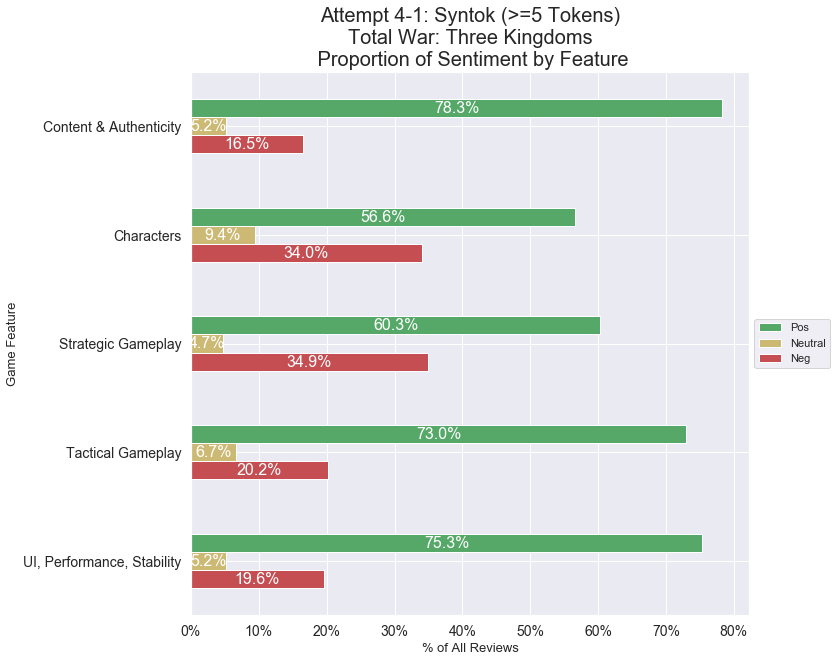

In [1521]:
#plot visualisation, 4th attempt at aggregation

#WARNING: 5 tokens is the MEDIAN number of tokens! This visualisation is for only HALF of the data!

ax = syntok_score_df_1.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Attempt 4-1: Syntok (>=5 Tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

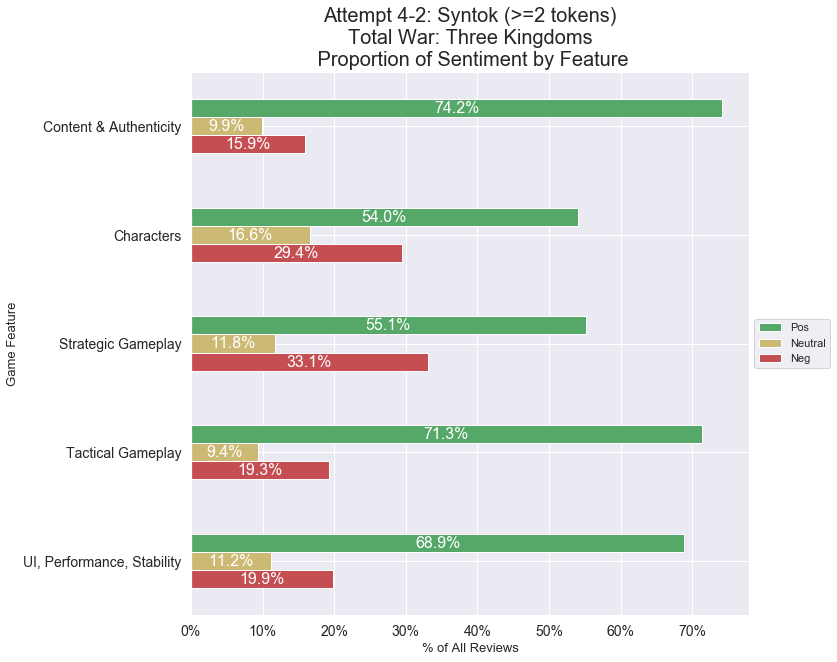

In [1522]:
#plot visualisation, 4th attempt at aggregation
#75% of the data is intact (2 tokens is 25th Percentile)

ax = syntok_score_df_2.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Attempt 4-2: Syntok (>=2 tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

# Review: 4th Attempt

The numbers with the Syntok tokenisation look similar to the 1st attempt, but are generally more believable and less likely to be due to random chance.

Long reviews are broken into paragraphs and scored according to the topic that dominates those paragraphs.

I find this to be a sweet spot that balances between the all the attempts. The 1st ignores the context of sentences in their respective reviews, the 2nd misses out too much data, and the 1st and 3rd both present risk of high misclassification rates because they go by extremely short sentences.

I will go with the 4th method of sentence parsing (using 2 or more tokens) and apply the same method of sentiment aggregation.

In [1552]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] >0.7) & (syntok_dom_topics['num_tokens']>5)
most_pos_df = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']]
most_pos_df.head()

,review_number,dominant_topic,original_text,compound_sentiment
0,7,Content & Authenticity,absolutely brilliant and beautiful game. worth...,0.9799
1,9,Content & Authenticity,great entry in the tw series ... while combat ...,0.8225
2,15,Content & Authenticity,"being newcomer to the total war franchise , ca...",0.7976
3,31,Content & Authenticity,( voice over ). game play : 7/10 some hero are...,0.9337
4,43,Content & Authenticity,what can say about this game ... at least you ...,0.9695


In [1528]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] <-0.5) & (syntok_dom_topics['num_tokens']>5)
syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']].head()

,review_number,dominant_topic,original_text,compound_sentiment
0,141,Content & Authenticity,really fun but one seriously bad issue is that...,-0.5128
1,826,"UI, Performance, Stability",was not really fan of the history of china unt...,-0.9112
2,963,Content & Authenticity,"huge fan of the total war franchise , and this...",-0.6124
3,1155,Content & Authenticity,the campaign and battle layers make what is ha...,-0.8257
4,1929,Content & Authenticity,"sure love this game pretty much , but since th...",-0.9267


In [1559]:
#Currently, sentiment scores do not account for class balance, so the data is noisy
#weight the scores by the class balance
syntok_dom_topics['dominant_topic'].value_counts(normalize=True)

Content & Authenticity        0.546627
Tactical Gameplay             0.214458
Strategic Gameplay            0.126579
Characters                    0.059393
UI, Performance, Stability    0.052943
Name: dominant_topic, dtype: float64

In [1561]:
cls_weights = dict(syntok_dom_topics['dominant_topic'].value_counts(normalize=True))
cls_weights

{'Content & Authenticity': 0.5466272507390486,
 'Tactical Gameplay': 0.21445847890352057,
 'Strategic Gameplay': 0.12657887664606288,
 'Characters': 0.05939263638806772,
 'UI, Performance, Stability': 0.052942757323300185}

In [1565]:
for key, value in cls_weights.items():
    cls_weights[key] = 1-value    #give more weight to items that appear less in the class

cls_weights

{'Content & Authenticity': 0.4533727492609514,
 'Tactical Gameplay': 0.7855415210964795,
 'Strategic Gameplay': 0.8734211233539371,
 'Characters': 0.9406073636119323,
 'UI, Performance, Stability': 0.9470572426766998}

In [1568]:
wtd_score_lst = []

for i in range(len(syntok_dom_topics)):
    wtd_score = cls_weights[syntok_dom_topics['dominant_topic'][i]] * syntok_dom_topics['compound_sentiment'][i]
    
    wtd_score_lst.append(wtd_score)


syntok_dom_topics['weighted_compound_sentiment'] = wtd_score_lst
syntok_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores,weighted_compound_sentiment
0,0,Tactical Gameplay,0.5171,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"unit, battle, faction, army, general, characte...",1. diplomacy it is joke. nothing works. you ha...,-0.9541,-1,-0.749485
1,0,Tactical Gameplay,0.5452,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...,-0.1280,-1,-0.100549
2,0,Strategic Gameplay,0.5152,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"faction, army, diplomacy, vassal, war, player,...",3. city building. tons of buildings that you w...,-0.7448,-1,-0.650524
3,1,Tactical Gameplay,0.6944,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"unit, battle, faction, army, general, characte...",pursued lu bu. now am lu bu.,0.0000,0,0.000000
4,2,Content & Authenticity,0.5761,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...,0.8519,1,0.386228


In [1642]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.8) & (syntok_dom_topics['weighted_compound_sentiment'] >0.7) & (syntok_dom_topics['num_tokens']>=5)
most_pos_df_2 = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
most_pos_df_2 = most_pos_df_2.sort_values(['weighted_compound_sentiment'],ascending=False).reset_index(drop=True)
# most_pos_df_2 = most_pos_df_2.sort_values(['compound_sentiment'],ascending=False).reset_index(drop=True)
most_pos_df_2.head(3)

,review_number,dominant_topic,original_text,tokens,compound_sentiment,weighted_compound_sentiment
0,476,Characters,"excellent art style , thrilling gameplay and d...","[art_style, gameplay, figure, strategy, time]",0.9400,0.884171
1,3485,Characters,loved the game. one of the best total wars and...,"[one_best_total_wars, route, strategy, god, bl...",0.8045,0.756719
2,2119,Tactical Gameplay,sun jian chase after my small troops form luji...,"[sun_jian, chase, troop, ambush, midway, captu...",0.9607,0.754670


In [1641]:
for i in range(3):
    print(most_pos_df_2['dominant_topic'][i],"-",most_pos_df_2['original_text'][i]+"\n\n","[Tokens]:",most_pos_df_2['tokens'][i],"\n\n")

Characters - excellent art style , thrilling gameplay and dynamic storyline/setting. absolutely loving playing each legendary figure and trying different strategies each time.

 [Tokens]: ['art_style', 'gameplay', 'figure', 'strategy', 'time'] 


Characters - loved the game. one of the best total wars and am very happy they are going this route. also for the loved of the strategy god were is the blood dlc? if you are going to sell it okey but at least give us the blood dlc on day one .... .

 [Tokens]: ['one_best_total_wars', 'route', 'strategy', 'god', 'blood_dlc', 'blood_dlc', 'day_one'] 


Tactical Gameplay - sun jian chase after my small troops form lujiang to boyang. ambush him in the midway and capture him then chop his head off. am so satisfied when my trick is working. am so satisfied by playing this game. best three kindoms game ever. hope you guys also enjoy it.

 [Tokens]: ['sun_jian', 'chase', 'troop', 'ambush', 'midway', 'capture', 'chop', 'head', 'trick', 'kindom', 'guy']

In [1643]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.8) & (syntok_dom_topics['weighted_compound_sentiment'] <-0.5) & (syntok_dom_topics['num_tokens']>=5)
most_neg_df_2 = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
most_neg_df_2 = most_neg_df_2.sort_values(['weighted_compound_sentiment'],ascending=True).reset_index(drop=True) #Ascending = TRUE to get the most negative reviews first
#most_neg_df_2 = most_neg_df_2.sort_values(['compound_sentiment'],ascending=False).reset_index(drop=True)
most_neg_df_2.head(3)

,review_number,dominant_topic,original_text,tokens,compound_sentiment,weighted_compound_sentiment
0,2853,Characters,killed an enemy general and his army at my tow...,"[enemy, army, town, border, capture, stack]",-0.8402,-0.790298
1,2231,Strategic Gameplay,- armies feel small. when will be have units w...,"[army, unit, soldier, war, battle, soldier, da...",-0.8840,-0.772104
2,2368,Tactical Gameplay,make an ally get into coalition get into your ...,"[ally, coalition, ally, war, because, love, shit]",-0.7837,-0.615629


In [1640]:
for i in range(3):
    print(most_neg_df_2['dominant_topic'][i],"-",most_neg_df_2['original_text'][i]+"\n\n","[Tokens]:",most_neg_df_2['tokens'][i],"\n\n")

Characters - killed an enemy general and his army at my town. marched over the border to capture his. he is sitting there with full stack.

 [Tokens]: ['enemy', 'army', 'town', 'border', 'capture', 'stack'] 


Strategic Gameplay - - armies feel small. when will be have units with 1000 soldiers? this war had battles where more than 100000 soldiers died in day. 2000 vs 2000 feels meh. almost all cons can be solved with mods. so. even if it is not perfect , mods can help.

 [Tokens]: ['army', 'unit', 'soldier', 'war', 'battle', 'soldier', 'day', 'meh', 'con', 'mod', 'mod', 'help'] 


Tactical Gameplay - make an ally get into coalition get into your various allies ´s wars get betrayed keep playing cause fucking love this shit.

 [Tokens]: ['ally', 'coalition', 'ally', 'war', 'because', 'love', 'shit'] 




# Assessment of weighted compound scores

Weighted compound scores seem to have a good impact. 

Also, taking reviews that have 80% topic dominance really helps to ensure that the sentences picked out for "most positive" and "most negative" will be quite accurate.

However, sentiment scoring isn't perfect. 1 of the 3 "most negative" reviews was actually positive, but the use of swear words and typically "negative" words like "shit" is commonplace in game communities. This can be read by VADER as negative although they are used to make a positive statement. 

Removing them is not really a solution either, because there will be negative reviews that use these words.

Although the use of sarcasm detection packages may help further reduce noise<span style="color:green"> the model is working as intended.</span> 

Further exploration at this time is likely to yield diminishing returns. 

I will proceed with deployment first, then come back to tweaking this later.

If sarcasm detection changes very little about the analysis, we may just have to accept this degree of inaccuracy as part and parcel of Internet gamer culture.

In [1649]:
syntok_dom_topics.to_csv('./dataframes/deployment/syntok_dom_topics.csv')
syntok_score_df_2.to_csv('./dataframes/deployment/syntok_score_df_2.csv')
most_pos_df_2.to_csv('./dataframes/deployment/most_pos_df_2.csv')
most_neg_df_2.to_csv('./dataframes/deployment/most_neg_df_2.csv')

# References

https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6
https://github.com/nuwapi/DoctorSnapshot/
https://github.com/fnl/syntok/blob/master/README.rst